# Objective

Demonstrate how self training can be used to supplement ML classification accuracy when a majority of the data available are unlabeled.

20% of data set aside as test set

20% of data kept as labeled train set

60% of data designated as 'unlabeled' - labels removed


# Imports

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Obtain Data

In [162]:
# Load data

df = pd.read_csv('heart_data.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Scrub Data

In [163]:
# Shuffle the data

df = df.sample(frac=1, random_state=1).reset_index(drop=True)

In [205]:
# Generate indices for splits

test_ind = round(len(df)*0.2)
train_ind = test_ind + round(len(df)*0.2)
unlabeled_ind = train_ind + round(len(df)*0.6)

In [206]:
# Partition the data

test = df.iloc[:test_ind]
train = df.iloc[test_ind:train_ind]
unlabeled = df.iloc[train_ind:unlabeled_ind]

In [170]:
X_train = train.drop('target', axis=1)
y_train = train.target

X_unlabeled = unlabeled.drop('target', axis=1)

X_test = test.drop('target', axis=1)
y_test = test.target

In [210]:
# Logistic Regression Classifier

clf = LogisticRegression(max_iter=1000)

clf.fit(X_train, y_train)
y_hat_test = clf.predict(X_test)
y_hat_train = clf.predict(X_train)

In [212]:
trainaccuracy_score(y_test, y_hat_test)

accuracy_score(y_train, y_hat_train)

0.9333333333333333

In [173]:
confusion_matrix(y_test, y_hat_test)

array([[26,  9],
       [14, 27]], dtype=int64)

In [174]:
u_probs = clf.predict_proba(X_unlabeled)
u_preds = clf.predict(X_unlabeled)

In [175]:
prob_diff = abs(np.subtract(u_probs[:,0], u_probs[:,1]))

In [176]:
X_unlabeled.index

RangeIndex(start=106, stop=303, step=1)

In [177]:
df_unlab_preds = pd.DataFrame([])

In [178]:
df_unlab_preds['preds'] = u_preds
df_unlab_preds['prob_diff'] = prob_diff

In [179]:
df_unlab_preds.index = X_unlabeled.index

In [180]:
df_unlab_preds

,preds,prob_diff
106,0,0.999672
107,0,1.000000
108,0,0.760606
109,0,0.996796
110,1,0.878599
...,...,...
298,0,0.989166
299,0,0.999364
300,1,0.999759
301,0,0.997770


In [181]:
top_preds = df_unlab_preds.sort_values(by='prob_diff', ascending=False)[:10]
top_preds_index = df_unlab_preds.sort_values(by='prob_diff', ascending=False)[:10].index

In [182]:
X_unlabeled.loc[top_preds_index]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
204,54,0,2,135,304,1,1,170,0,0.0,2,0,2
263,50,0,2,120,219,0,1,158,0,1.6,1,0,2
260,71,0,1,160,302,0,1,162,0,0.4,2,2,2
226,35,0,0,138,183,0,1,182,0,1.4,2,0,2
143,51,0,2,140,308,0,0,142,0,1.5,2,1,2
187,51,0,2,120,295,0,0,157,0,0.6,2,0,2
186,45,0,1,112,160,0,1,138,0,0.0,1,0,2
146,62,0,0,124,209,0,1,163,0,0.0,2,0,2
147,44,0,2,108,141,0,1,175,0,0.6,1,0,2
258,66,0,2,146,278,0,0,152,0,0.0,1,1,2


In [183]:
pd.concat([X_train, X_unlabeled.loc[top_preds_index]], axis=0)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
76,56,1,2,130,256,1,0,142,1,0.6,1,1,1
77,54,1,0,120,188,0,1,113,0,1.4,1,1,3
78,63,1,0,130,254,0,0,147,0,1.4,1,1,3
79,45,1,0,104,208,0,0,148,1,3.0,1,0,2
80,48,1,2,124,255,1,1,175,0,0.0,2,2,2
81,42,1,1,120,295,0,1,162,0,0.0,2,0,2
82,57,1,0,152,274,0,1,88,1,1.2,1,1,3
83,57,1,0,140,192,0,1,148,0,0.4,1,0,1
84,54,0,1,132,288,1,0,159,1,0.0,2,1,2
85,65,0,2,155,269,0,1,148,0,0.8,2,0,2


In [184]:
pd.concat([y_train, top_preds.preds])

76     0
77     0
78     0
79     1
80     1
81     1
82     0
83     1
84     1
85     1
86     1
87     1
88     1
89     0
90     0
91     1
92     0
93     0
94     1
95     0
96     0
97     0
98     1
99     1
100    1
101    0
102    0
103    1
104    0
105    1
204    1
263    1
260    1
226    1
143    1
187    1
186    1
146    1
147    1
258    1
dtype: int64

In [185]:
X_unlabeled.drop(index=top_preds_index)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
106,48,1,1,110,229,0,1,168,0,1.0,0,0,3
107,53,1,0,123,282,0,1,95,1,2.0,1,2,3
108,48,1,1,130,245,0,0,180,0,0.2,1,0,2
109,58,1,2,105,240,0,0,154,1,0.6,1,0,3
110,59,1,3,134,204,0,1,162,0,0.8,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,68,1,2,180,274,1,0,150,1,1.6,1,0,3
299,45,1,0,142,309,0,0,147,1,0.0,1,3,3
300,29,1,1,130,204,0,0,202,0,0.0,2,0,2
301,51,1,0,140,299,0,1,173,1,1.6,2,0,3


Function to perform self training for classification

In [186]:
def self_training_classification (X_train, y_train, X_unlabeled, X_test, 
                                 y_test, classifier, step_size):
    
    step = 0
    train_accs = []
    test_accs = []
    
    while len(X_unlabeled) > step_size:
        
        # Fit classifier and make train/test predictions
        clf = classifier
        clf.fit(X_train, y_train)
        y_hat_train = clf.predict(X_train)
        y_hat_test = clf.predict(X_test)


        train_acc = accuracy_score(y_train, y_hat_train)
        test_acc = accuracy_score(y_test, y_hat_test)

        print(f"Train Accuracy: {train_acc}")
        print(f"Test Accuracy: {test_acc}")
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        print(f"Now predicting labels for unlabeled data - iteration {step}...")

        u_probs = clf.predict_proba(X_unlabeled)
        u_preds = clf.predict(X_unlabeled)

        prob_diff = abs(np.subtract(u_probs[:,0], u_probs[:,1]))

        df_unlab_preds = pd.DataFrame([])
        df_unlab_preds['preds'] = u_preds
        df_unlab_preds['prob_diff'] = prob_diff
        df_unlab_preds.index = X_unlabeled.index

        top_preds = df_unlab_preds.sort_values(by='prob_diff', ascending=False)[:step_size]
        top_preds_index = df_unlab_preds.sort_values(by='prob_diff', ascending=False)[:step_size].index

        X_train = pd.concat([X_train, X_unlabeled.loc[top_preds_index]], axis=0)
        y_train = pd.concat([y_train, top_preds.preds])      
        X_unlabeled = X_unlabeled.drop(index=top_preds_index)

        step += 1
        
    return train_accs, test_accs

In [202]:
train_accs, test_accs = self_training_classification(X_train, y_train, 
                                                     X_unlabeled, 
                                                     X_test, y_test, 
                                                     LogisticRegression(max_iter=1000), 
                                                     step_size = 5)

Train Accuracy: 0.9333333333333333
Test Accuracy: 0.6710526315789473
Now predicting labels for unlabeled data - iteration 0...
Train Accuracy: 0.9428571428571428
Test Accuracy: 0.6710526315789473
Now predicting labels for unlabeled data - iteration 1...
Train Accuracy: 0.95
Test Accuracy: 0.6710526315789473
Now predicting labels for unlabeled data - iteration 2...
Train Accuracy: 0.9555555555555556
Test Accuracy: 0.6710526315789473
Now predicting labels for unlabeled data - iteration 3...
Train Accuracy: 0.96
Test Accuracy: 0.6710526315789473
Now predicting labels for unlabeled data - iteration 4...
Train Accuracy: 0.9636363636363636
Test Accuracy: 0.6710526315789473
Now predicting labels for unlabeled data - iteration 5...
Train Accuracy: 0.9666666666666667
Test Accuracy: 0.6710526315789473
Now predicting labels for unlabeled data - iteration 6...
Train Accuracy: 0.9692307692307692
Test Accuracy: 0.6710526315789473
Now predicting labels for unlabeled data - iteration 7...
Train Accura

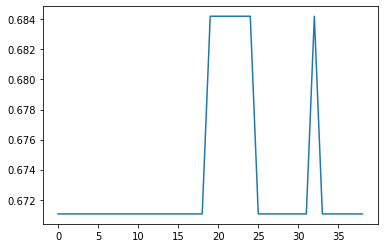

In [204]:
plt.plot(range(39), test_accs)
#plt.plot(range(18), train_accs);